<a href="https://www.kaggle.com/code/deepakvk18/titanic-survival-prediction?scriptVersionId=101876203" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Problem Statement

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

### Datasets
Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not, also known as the “ground truth”.

The `test.csv` dataset contains similar information but does not disclose the “ground truth” for each passenger. It’s your job to predict these outcomes.

You can download the dataset from [here](https://www.kaggle.com/competitions/titanic/data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve,roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
plt.style.use('seaborn-bright')

# Importing the Data and Understanding the features in the data

In [3]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
submission_df = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Features in the dataset


**survival**	Survival	0 = No, 1 = Yes

**pclass**	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
            A proxy for socio-economic status (SES)
            1st = Upper
            2nd = Middle
            3rd = Lower
            
**sex**  ->  Sex

**Age**  ->  Age in years
             Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
            
**sibsp** -> # of siblings / spouses aboard the Titanic	
             sibsp: The dataset defines family relations in this way...
             Sibling = brother, sister, stepbrother, stepsister
             Spouse = husband, wife (mistresses and fiancés were ignored)

**parch** -> # of parents / children aboard the Titanic	
             parch: The dataset defines family relations in this way...
             Parent = mother, father
             Child = daughter, son, stepdaughter, stepson
             Some children travelled only with a nanny, therefore parch=0 for them.

**ticket**-> Ticket number	

**fare**  -> Passenger fare	

**cabin** -> Cabin number	

**embarked**-> Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton


# Cleaning and Imputing data

In [6]:
def impute_data(dataframe):
    #Filling in the na values of Embarked column as S as 
                                    #It is where most of the passengers boarded the ship
    dataframe['Embarked'].fillna('S', inplace = True)
    
    #Filling in na values of Age column by mean of 
    dataframe.Age.fillna(train_df.Age.mean(), inplace = True)
    dataframe.Fare.fillna(test_df.Fare.mean(), inplace=True)
    return dataframe

In [7]:
impute_data(train_df).isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

# Exploratory Data Analysis

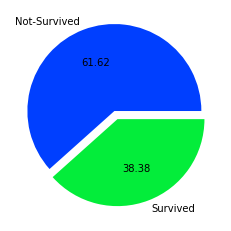

In [8]:
eda_df = impute_data(train_df).fillna('Uncategorized')
pie_df = train_df[['Survived','PassengerId']].groupby(by = 'Survived').count()
plt.pie(x=pie_df['PassengerId'], labels=['Not-Survived','Survived'],explode=[0.05,0.05], autopct='%.2f');

It seems that less than 40% of people survived the clash.

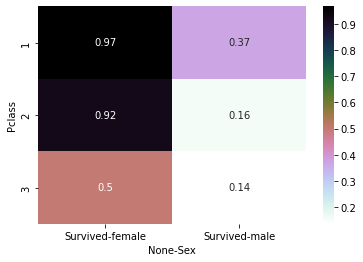

In [9]:
pivot = train_df[['Pclass','Survived','Sex']].groupby(['Pclass','Sex']).mean().unstack()
sns.heatmap(pivot, annot=True,cmap='cubehelix_r');

The above heatmap denotes that the women had a higher chance of survival when compared to men during the disaster.

In [10]:
eda_df['Relatives'] = eda_df['SibSp']+eda_df['Parch']
eda_df[['PassengerId','Relatives','Survived']].groupby('Relatives').agg({'PassengerId':'count','Survived':'mean'})

,PassengerId,Survived
Relatives,,
0,537,0.303538
1,161,0.552795
2,102,0.578431
3,29,0.724138
4,15,0.200000
5,22,0.136364
6,12,0.333333
7,6,0.000000
10,7,0.000000


The above table represents that people who have lesser relatives on board the ship had more chance of survival than the people with more number of relatives.

In [11]:
eda_df.groupby(by = 'Embarked').mean()['Survived']

Embarked
C    0.553571
Q    0.389610
S    0.339009
Name: Survived, dtype: float64

The table shows that the people who embarked from Cherbourg had more chance of survival when compared to the others.

# Preparing Data to build the model

In [12]:
numerical_cols = ['PassengerId','Pclass','Age','SibSp','Parch','Fare']
categorical_cols = ['Embarked','Sex']
encoded_cols = pd.get_dummies(train_df[categorical_cols]).columns
def encode_categorical(dataframe):
    dataframe = impute_data(dataframe)
    dataframe[encoded_cols] = pd.get_dummies(train_df[categorical_cols])
    return dataframe
train_df = encode_categorical(train_df)
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,0,1,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,1


In [13]:
input_cols = list(numerical_cols) + list(encoded_cols)
input_cols

['PassengerId',
 'Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Sex_female',
 'Sex_male']

In [14]:
inputs = train_df[input_cols]
target = train_df['Survived']

## Splitting the data into train data and test data

In [15]:
train_x, test_x, train_y, test_y = train_test_split(inputs,target, train_size = 0.33, random_state = 42)

# Building Machine Learning Models

### 1. Naive Bayes Classifier

Train Macro F1 ~ 0.80

Test Macro F1 ~ 0.80

Unknown Data Score ~ 0.60

In [16]:
bnb = BernoulliNB(alpha=0.05, fit_prior=False)
bnb.fit(train_x, train_y)
print(classification_report(train_y, bnb.predict(train_x)))
print("------------------------------------------------------------")
print(classification_report(test_y, bnb.predict(test_x)))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       185
           1       0.72      0.66      0.69       109

    accuracy                           0.78       294
   macro avg       0.76      0.75      0.76       294
weighted avg       0.78      0.78      0.78       294

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       364
           1       0.72      0.71      0.72       233

    accuracy                           0.78       597
   macro avg       0.77      0.77      0.77       597
weighted avg       0.78      0.78      0.78       597




The score that I got for the model was 0.60 which is very less when compared to the accuracy that I got above.

This is the disadvantage of Naive Bayes since this model assumes that all the features are independent of each other but in reality they are not.

I am going to build other models and tune the hyper parameters as well to achieve the maximum accuracy.

### 2. Building a Decision Tree Model
Train Macro F1 ~ 0.77

Test Macro F1 ~ 0.77

Unknown Data Score ~ 0.58

In [17]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_x, train_y)
print(classification_report(train_y, dt.predict(train_x)))
print("------------------------------------------------------------")
print(classification_report(test_y, dt.predict(test_x)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       185
           1       1.00      1.00      1.00       109

    accuracy                           1.00       294
   macro avg       1.00      1.00      1.00       294
weighted avg       1.00      1.00      1.00       294

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       364
           1       0.66      0.70      0.68       233

    accuracy                           0.74       597
   macro avg       0.73      0.73      0.73       597
weighted avg       0.74      0.74      0.74       597



In [18]:
roc_auc_score(test_y, dt.predict_proba(test_x)[:,1])

0.7337994623402349

This model is severely over fitted since train accuracy in almost 98 and the test accuracy is not even 80. To overcome overfitting, hyper parameters are tuned.

##### Tuning Hyperparameters of Decision Tree Classifier

In [19]:
def test_params_dt(**params):
    model = DecisionTreeClassifier(random_state=42, **params).fit(train_x, train_y)
    train_accuracy = accuracy_score(model.predict(train_x), train_y)
    val_accuracy = accuracy_score(model.predict(test_x), test_y)
    return train_accuracy, val_accuracy

In [20]:
def test_param_and_plot_dt(param_name, param_values):
    train_accuracies, test_accuracies = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_accuracy, test_accuracy = test_params_dt(**params)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_accuracies, 'b-o')
    plt.plot(param_values, test_accuracies, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])

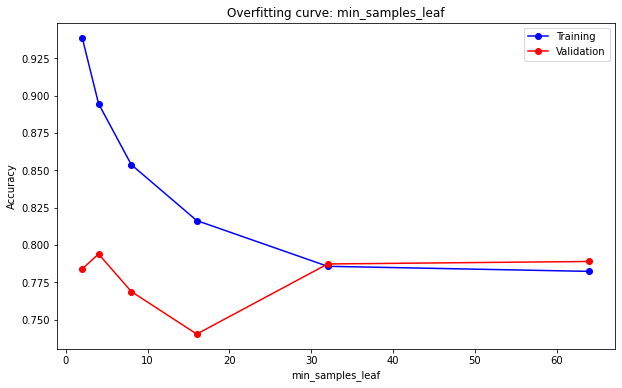

In [21]:
test_param_and_plot_dt('min_samples_leaf',[2,4,8,16,32,64])

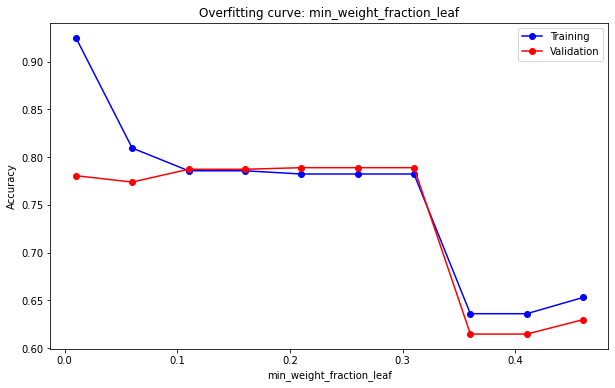

In [22]:
test_param_and_plot_dt('min_weight_fraction_leaf',np.arange(0.01,0.5,0.05))

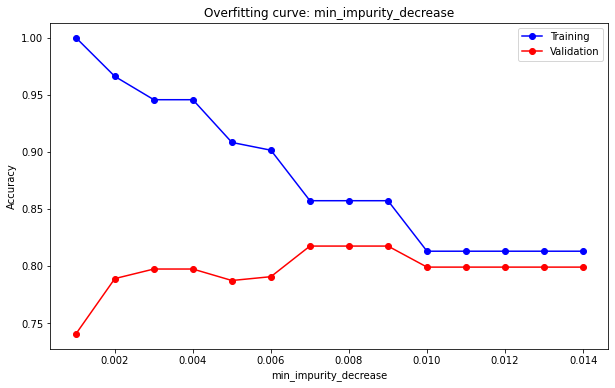

In [23]:
test_param_and_plot_dt('min_impurity_decrease',np.arange(0.001,0.015,0.001))

In [24]:
params = {
    'min_impurity_decrease':[0.01,0.09,0.11],
    'min_samples_leaf':np.arange(25,35),
    'min_weight_fraction_leaf': np.arange(0.1,0.2,0.01)
}

dtrandomCV = RandomizedSearchCV(
                estimator=DecisionTreeClassifier(random_state=42),
                                param_distributions=params,
                                 n_jobs = -1,
                                scoring='roc_auc',
                                error_score=np.nan,
                                random_state=42)

dtrandomCV.fit(train_x, train_y)
dtrandomCV.best_params_

{'min_weight_fraction_leaf': 0.14999999999999997,
 'min_samples_leaf': 25,
 'min_impurity_decrease': 0.01}

In [25]:
kfold = StratifiedKFold(n_splits=3,random_state=42, shuffle=True)
for train_index, test_index in kfold.split(train_df[input_cols],train_df['Survived']):
    X_train, X_test = train_df.loc[train_index,:], train_df.loc[test_index,:]
    y_train, y_test = train_df.loc[train_index,:]['Survived'], train_df.loc[test_index,:]['Survived']
    model = dtrandomCV
    model.fit(X_train[input_cols],y_train)
    print("Train acc:",accuracy_score(y_train,model.predict(X_train[input_cols])),
                                     "\nTest acc:",accuracy_score(y_test,model.predict(X_test[input_cols])),
                                     "\n-------------------------------------------------")

Train acc: 0.7946127946127947 
Test acc: 0.7710437710437711 
-------------------------------------------------
Train acc: 0.7946127946127947 
Test acc: 0.7710437710437711 
-------------------------------------------------
Train acc: 0.7811447811447811 
Test acc: 0.797979797979798 
-------------------------------------------------


In [26]:
roc_auc_score(test_y, dtrandomCV.predict_proba(test_x)[:,1])

0.8122199688723294

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       185
           1       0.73      0.66      0.69       109

    accuracy                           0.78       294
   macro avg       0.77      0.76      0.76       294
weighted avg       0.78      0.78      0.78       294

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       364
           1       0.75      0.69      0.72       233

    accuracy                           0.79       597
   macro avg       0.78      0.77      0.77       597
weighted avg       0.79      0.79      0.79       597



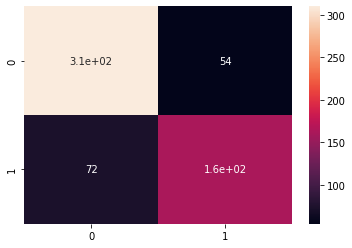

In [27]:
print(classification_report(train_y, dtrandomCV.predict(train_x)))
print("------------------------------------------------------------")
print(classification_report(test_y, dtrandomCV.predict(test_x)))
sns.heatmap(confusion_matrix(test_y, dtrandomCV.predict(test_x)), annot=True);

Here is the convergence. Although the accuracies are converged, the False Negatives are too many.

Let me train Random Forest Model for better performance.

### 3. Building Random Forest Classifier

Train Macro F1 ~ 0.77

Test Macro F1 ~ 0.77

Unknown Data Score ~ 0.787

In [28]:
rf = RandomForestClassifier(random_state=42)

rf.fit(train_x, train_y)
print(classification_report(train_y, rf.predict(train_x)))
print("------------------------------------------------------------")
print(classification_report(test_y, rf.predict(test_x)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       185
           1       1.00      1.00      1.00       109

    accuracy                           1.00       294
   macro avg       1.00      1.00      1.00       294
weighted avg       1.00      1.00      1.00       294

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       364
           1       0.75      0.67      0.71       233

    accuracy                           0.79       597
   macro avg       0.78      0.77      0.77       597
weighted avg       0.79      0.79      0.78       597



In [29]:
roc_auc_score(test_y, rf.predict_proba(test_x)[:,1])

0.8487478187049002

### Tuning the Hyper Parameters

In [30]:
def test_params_rf(**params):
    model = RandomForestClassifier(random_state=42, **params).fit(train_x, train_y)
    train_accuracy = accuracy_score(model.predict(train_x), train_y)
    val_accuracy = accuracy_score(model.predict(test_x), test_y)
    return train_accuracy, val_accuracy

In [31]:
def test_param_and_plot_rf(param_name, param_values):
    train_accuracies, test_accuracies = [],[]
    for value in param_values:
        params = {param_name: value}
        train_accuracy, test_accuracy = test_params_dt(**params)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_accuracies, 'b-o')
    plt.plot(param_values, test_accuracies, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])

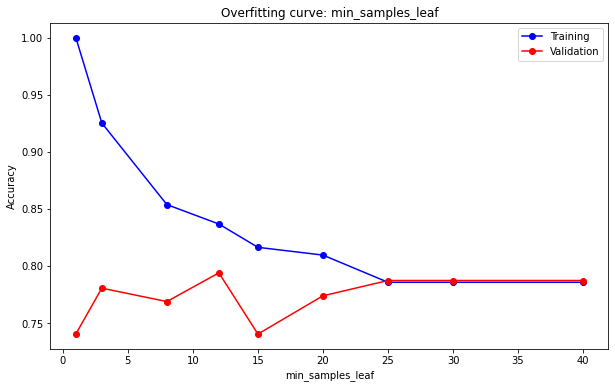

In [32]:
test_param_and_plot_rf('min_samples_leaf',[1,3,8,12,15,20,25,30,40])

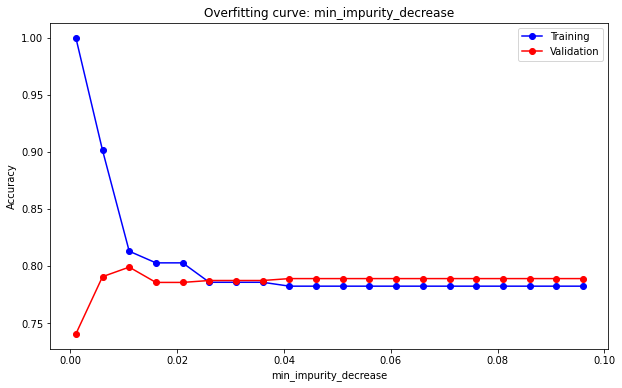

In [33]:
test_param_and_plot_rf('min_impurity_decrease', np.arange(0.001,0.1,0.005))

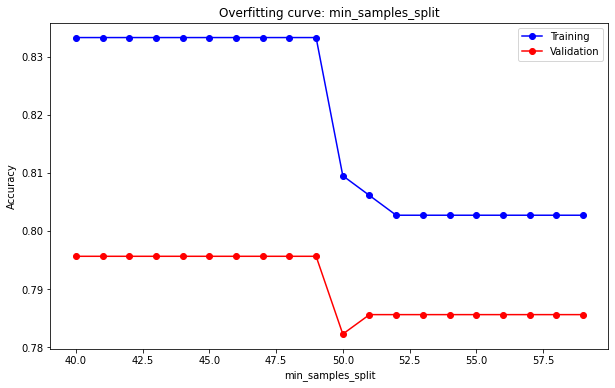

In [34]:
test_param_and_plot_rf('min_samples_split', np.arange(40,60))

In [35]:
params = {
    'min_impurity_decrease':[0.02,0.03,0.04],
    'min_samples_leaf':[25,30],
    'class_weight':['balanced','balanced_subsample'],
    'min_samples_split':[51,52,55,56],
    'max_samples': np.arange(0.1,1,0.1)
}

rfrandomCV = RandomizedSearchCV(
                estimator=RandomForestClassifier(n_jobs=-1,random_state=42),
                                param_distributions=params,
                                 n_jobs = -1,
                                scoring='roc_auc',
                                error_score=np.nan)

rfrandomCV.fit(train_x, train_y)
rfrandomCV.best_params_

{'min_samples_split': 52,
 'min_samples_leaf': 25,
 'min_impurity_decrease': 0.04,
 'max_samples': 0.9,
 'class_weight': 'balanced_subsample'}

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       185
           1       0.73      0.66      0.69       109

    accuracy                           0.78       294
   macro avg       0.77      0.76      0.76       294
weighted avg       0.78      0.78      0.78       294

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       364
           1       0.75      0.69      0.72       233

    accuracy                           0.79       597
   macro avg       0.78      0.77      0.77       597
weighted avg       0.79      0.79      0.79       597



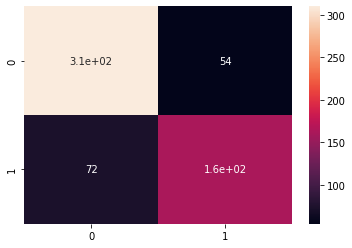

In [36]:
print(classification_report(train_y, rfrandomCV.predict(train_x)))
print("------------------------------------------------------------")
print(classification_report(test_y, rfrandomCV.predict(test_x)))
sns.heatmap(confusion_matrix(test_y, rfrandomCV.predict(test_x)), annot=True);

#### Validating the Model

In [37]:
kfold = StratifiedKFold(n_splits=3,random_state=42, shuffle=True)
for train_index, test_index in kfold.split(train_df[input_cols],train_df['Survived']):
    X_train, X_test = train_df.loc[train_index,:], train_df.loc[test_index,:]
    y_train, y_test = train_df.loc[train_index,:]['Survived'], train_df.loc[test_index,:]['Survived']
    model = rfrandomCV
    model.fit(X_train[input_cols],y_train)
    print("Train acc:",accuracy_score(y_train,model.predict(X_train[input_cols])),
                                     "\nTest acc:",accuracy_score(y_test,model.predict(X_test[input_cols])),
                                     "\n-------------------------------------------------")

Train acc: 0.7845117845117845 
Test acc: 0.7912457912457912 
-------------------------------------------------
Train acc: 0.7946127946127947 
Test acc: 0.7710437710437711 
-------------------------------------------------
Train acc: 0.7811447811447811 
Test acc: 0.797979797979798 
-------------------------------------------------


The model has finally converged and the accuracy is maintained approximately at 78% in any step during k-fold cross validation.

In [38]:
roc_auc_score(test_y, rfrandomCV.predict_proba(test_x)[:,1])

0.8516896193934821

# Model Predictions for test Data

In [39]:
validation = test_df.copy()

In [40]:
input = encode_categorical(validation)[input_cols].copy()

predict_test = rfrandomCV.predict(input)

In [41]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predict_test})
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,1
3,895,1
4,896,0


In [42]:
output.to_csv('submission.csv', index = False)

# References
1. [How to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/#:~:text=The%20AUC%20for%20the%20ROC,skill%20and%20perfect%20skill%20respectively.)

2. [A Beginner’s Guide to Random Forest Hyperparameter Tuning](https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/#:~:text=This%20Random%20Forest%20hyperparameter%20specifies,node%20after%20splitting%20a%20node.&text=The%20tree%20on%20the%20left%20represents%20an%20unconstrained%20tree.,a%20minimum%20of%205%20samples.)

3. [A Comprehensive Guide to Decision trees](https://www.analyticsvidhya.com/blog/2021/07/a-comprehensive-guide-to-decision-trees/)

4. [RandomizedSearchCV - scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)



# Future Works

1. I would like to train a Deep Learning Model to predict the survivors better.

2. I would try to improve the predictions through linear models as well.